In [1]:
import dynesty
from dynesty import plotting as dyplot

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import os

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt
import scipy

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

import random

%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
nwalk = 64
nsteps = 1000
ndiscard = 500
arrlen = (nsteps-ndiscard)*nwalk

In [4]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## The Sample

In [9]:
muirhead_data = pd.read_csv("datafiles/Muirhead2013_isochrones/muirhead_data_incmissing.txt", sep=" ")

# ALL Kepler planets from exo archive
planets = pd.read_csv('datafiles/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = pd.read_csv('datafiles2/spectplanets.csv')

# Kepler-Gaia Data
kpgaia = Table.read('datafiles/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = pd.read_csv("datafiles2/muirhead_gaia.csv")

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.read_csv('datafiles2/muirhead_comb.csv')

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = pd.read_csv('datafiles2/muirhead_comb_lums.csv')

/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


# Defining a "test planet"

In [15]:
# Kepler ID for Kepler-1582 b
kepid = 5868793
kepoiname = spectplanets.loc[spectplanets['kepid'] == kepid].kepoi_name.values[0]

kp1582b = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]

In [16]:
isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

In [17]:
mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

In [18]:
rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err, arrlen)

# Creating a fake light curve based on a real planet

In [19]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, inc, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepoiname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', inc)

Stellar mass (Msun):  0.17438311970562165 Stellar radius (Rsun):  0.19884797856314
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  33.79155851141583
i (deg):  89.98


# --------------------------------------------------------------------------------------

# $e = 0.9$, $\omega = -85.0$

# --------------------------------------------------------------------------------------

In [20]:
# 30 minute cadence
cadence = 0.02142857142857143

time = np.arange(-25, 25, cadence)

In [23]:
# Calculate flux from transit model
e = 0.9
w = -85.0
flux = ph.integratedlc(time, period, rprs, a_rs, e, inc, w, 0)

# Adding some gaussian noise
noise = np.random.normal(0,0.00006,len(time))
nflux = flux+noise

flux_err = np.array([0.00006]*len(nflux))

# Fitting the transit

In [24]:
periodPDF = ph.get_period_dist(time, nflux, 4, 6, arrlen)

In [25]:
print('Period fit: ', ph.mode(periodPDF))
pdist = periodPDF
per_guess = ph.mode(pdist)

Period fit:  4.833667334669339


In [26]:
ttimes = np.concatenate((-np.arange(0, time[-1], period)[1:], np.arange(0, time[-1], period)))
ttimes = np.sort(ttimes)

time1, nflux1, fluxerr1 = ph.get_transit_cutout_full(ttimes, 4, time, nflux, flux_err)

t0 = 0.0

In [27]:
mid = ph.get_mid(time1)
ptime1 = ph.get_ptime(time1, mid, 29)

In [28]:
# Inital guess: period, rprs, a/Rs, i, w
p0 = [per_guess, rprs, 35, 89.9, 0.0]

dr = 'e_' + str(0) + '_w_' + str(w)
direct = 'plots_tutorial/' + dr + '/'

if not os.path.exists(direct):
    os.mkdir(direct)

# EMCEE Transit Model Fitting
_, _, pdist, rdist, adist, idist, t0dist = ph.mcmc_fitter(p0, time1, ptime1, nflux1, fluxerr1, nwalk, nsteps, ndiscard, e, w, direct)


100%|██████████| 1000/1000 [03:01<00:00,  5.52it/s]


NameError: name 'corner' is not defined

In [33]:
per_f = ph.mode(pdist)
rprs_f = ph.mode(rdist)
a_f = ph.mode(adist)
i_f = ph.mode(idist)
t0_f = ph.mode(t0dist)

In [34]:
# Create a light curve with the fit parameters
fit1 = ph.integratedlc_fitter(time, per_f, rprs_f, a_f, i_f, t0_f)

Stellar mass (Msun):  0.17438311970562165 Stellar radius (Rsun):  0.19884797856314


Input params:
Rp/Rs:  0.036066
a/Rs:  33.79155851141583
i (deg):  89.98


Fit params:
Rp/Rs:  0.03709749159020756
a/Rs:  5.934713080062197
i (deg):  89.92521702491366


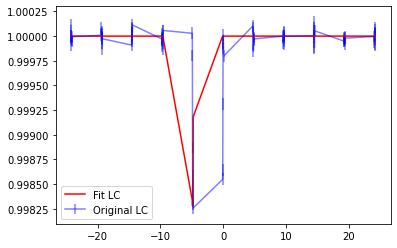

In [37]:
plt.errorbar(time1, nflux1, yerr=fluxerr1, c='blue', alpha=0.5, label='Original LC')
plt.plot(time1, fit1, c='red', alpha=1.0, label='Fit LC')
#plt.xlim(-0.1, 0.1)
plt.legend()

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)

print('\n')

print('Input params:')
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', inc)

print('\n')

print('Fit params:')
print('Rp/Rs: ', rprs_f)
print('a/Rs: ', a_f)
print('i (deg): ', i_f)

### Determining T14 and T23

In [38]:
T14dist = ph.get_T14(pdist, rdist, adist, idist)
T14errs = ph.get_sigmas(T14dist)

T23dist = ph.get_T23(pdist, rdist, adist, idist)
T23errs = ph.get_sigmas(T23dist)

# Get $g$

In [39]:
gs, rho_c = ph.get_g_distribution(rho_star, pdist, rdist, T14dist, T23dist)

g_mean = ph.mode(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

In [40]:
g_mean

0.1925054321910814

In [41]:
g_sigma

0.0818649418548385

In [42]:
g = g_mean
gerr = g_sigma

# Dynesty (e,w) Fitting LIkelihood Functions

In [43]:
ndim = 2

def loglike(theta):
    """The log-likelihood function."""

    w, e = theta
    
    model = (1+e*np.sin(w*(np.pi/180.)))/np.sqrt(1-e**2)
    sigma2 = gerr ** 2
    
    return -0.5 * np.sum((g - model) ** 2 / sigma2 + np.log(sigma2))

def unife_prior_transform(utheta):
    """Uniform eccentricity prior"""
    
    uw, ue = utheta
    w = 360.*uw-90.
    e = 1. * ue
    
    return w, e


def betae_prior_transform(utheta):
    """Uniform eccentricity prior"""
    
    uw, ue = utheta
    w = 360.*uw-90.
    
    a, b = 0.867, 3.03
    e = scipy.stats.beta.ppf(ue, a, b)
    
    return w, e

## Uniform Prior

In [44]:
dsampler = dynesty.DynamicNestedSampler(loglike, unife_prior_transform, ndim=2, bound='multi', sample='rstagger')

In [45]:
dsampler.run_nested()

20520it [02:07, 161.32it/s, batch: 11 | bound: 138 | nc: 1 | ncall: 439198 | eff(%):  4.672 | loglstar:   -inf <  2.503 <  2.412 | logz: -2.080 +/-  0.126 | stop:  0.939]       


In [46]:
dres = dsampler.results

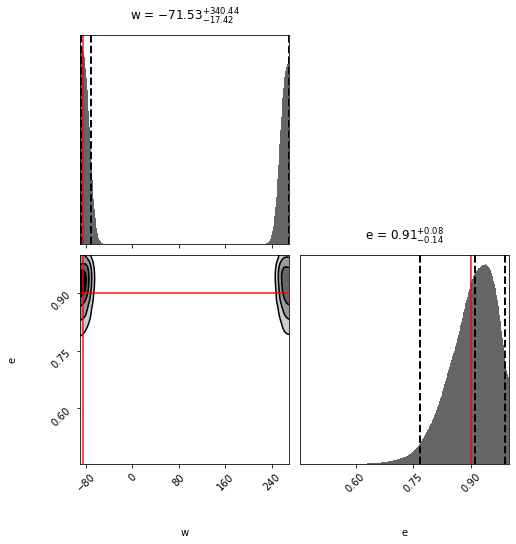

In [47]:
truths = [w, e]

fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, title_kwargs={'y': 1.04}, labels=["w", "e"],
                              fig=plt.subplots(2, 2, figsize=(8, 8)))

## Beta-distribution Prior

In [48]:
dsampler = dynesty.DynamicNestedSampler(loglike, betae_prior_transform, ndim=2, bound='multi', sample='rstagger')

In [49]:
dsampler.run_nested()

6628it [00:49, 104.14it/s, batch: 0 | bound: 66 | nc: 25 | ncall: 139423 | eff(%):  4.737 | loglstar:   -inf <  2.492 <    inf | logz: -6.232 +/-  0.163 | dlogz:  0.011 >  0.010] /Users/ssagear/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:381: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
18854it [03:37, 86.62it/s, batch: 7 | bound: 186 | nc: 25 | ncall: 433615 | eff(%):  4.348 | loglstar: -4.954 <  2.503 <  1.499 | logz: -6.181 +/-  0.149 | stop:  0.943]         


In [50]:
dres = dsampler.results

In [51]:
truths = [w, e]

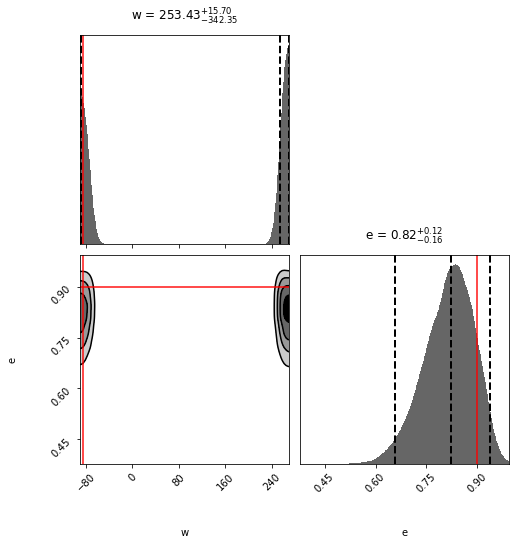

In [52]:
fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, title_kwargs={'y': 1.04}, labels=["w", "e"],
                              fig=plt.subplots(2, 2, figsize=(8, 8)))

In [53]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [54]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/ssagear/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:04<00:00, 1128.26it/s]


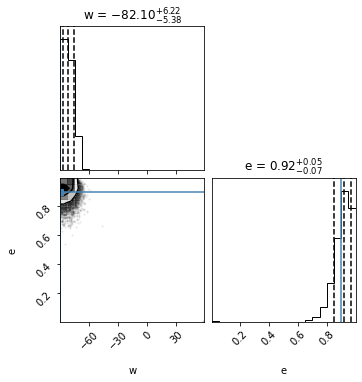

In [56]:
labels = ["w", "e"]

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels, show_titles=True, title_kwargs={"fontsize": 12}, truths=[-90.0, 0.9], quantiles=[0.16, 0.5, 0.84], plot_contours=True)